# The test of Coherences and Charge MMTs

The IBM platform, via qiskit.

Load the packages:

In [48]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from time import gmtime, strftime
import qiskit.tools.jupyter
%qiskit_version_table
import numpy as np

## Device Backend Noise Model

The *Qiskit Aer* device noise model automatically generates a simplified noise model for a real device. This model is generated using the calibration information reported in the `BackendProperties` of a device and takes into account

* The *gate_error* probability of each basis gate on each qubit.
* The *gate_length* of each basis gate on each qubit.
* The $T_1$, $T_2$ relaxation time constants of each qubit.
* The readout error probability of each qubit.

The backend import is as given below. See https://qiskit.org/documentation/apidoc/providers_fake_provider.html#fake-backends for more backend option. Aer does currently not support V2 backends, therefore, I chose a V1 backend of a 27 qubit machine (Mumbai).

In [49]:
from qiskit.providers.fake_provider import FakeMumbai

# Get a fake backend from the fake provider
backend = FakeMumbai()

## Group Structure

Group data needed for post-processing:

In [50]:
R = np.array([[0, -1],[1, 0]])
M = np.array([[1, 0],[0, -1]])
G = np.zeros([2,2,8])
G[:,:,0] = np.eye(2) # The D_4 group [via it's faithful 2d rep]
G[:,:,1] = R
G[:,:,2] = R@R
G[:,:,3] = R@R@R
G[:,:,4] = M
G[:,:,5] = M@R
G[:,:,6] = M@R@R
G[:,:,7] = M@R@R@R
g_lab = ['e','r','rr','rrr','m','mr','mrr','mrrr']
order = len(g_lab)
# Binary encoding: | M, R, RR> -> 8 element encoding needs to be translated in this formalism
encode = {'000':0,'010':1, '001':2, '011':3, '100':4,'110':5, '101':6, '111':7}

C_e = np.array([0])  # Conj Classes
C_r = np.array([1,3])
C_rr = np.array([2])
C_m = np.array([4,6])
C_mr = np.array([5,7])

Z_e = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # Centers Classes
Z_r = np.array([0, 1, 2, 3])
Z_rr = np.array([0, 1, 2, 3, 4, 5, 6, 7])
Z_m = np.array([0, 2, 4, 6])
Z_mr = np.array([0, 2, 5, 7])

Function to query the group structure:

In [51]:
def dag(M):
    return np.conjugate(M.T)
def matInv(M):
    return np.linalg.inv(M)
def is_eq(A,B):
    return np.array_equal(A,B)

def q(c):
    Q_C = [0, 0, 0, 4, 0, 0, 3, 3] # This for q_c instead : Coset Representatives
    return Q_C[c]

def grp(x):
    return G[:,:,x] # USE G AS A GLOBAL VAR!!! ---- CAREFUL !


def grp_i(i):
    return matInv(G[:,:,i])

def index(h):
    for i in range(8): # to be generalised
        if np.array_equal(h, G[:,:,i]):
            return i

def inv(x):
    for i in range(8): # to be generalised
        if np.array_equal(matInv(G[:,:,x]), G[:,:,i]):
            return i

# Implement Circuit on 27 qubit machine



In [52]:
# Mapping the old layout to the qubits of the IBM machine

g0=0
g1=1
g2=2
g3=3
g4=4
g5=5
g6=6
g7=7
g8=8
g9=9
g10=10
g11=11
g12=12
g13=13
g14=14
g15=15
g16=16
g17=17
g18=18
g19=19
g20=20
g21=21
g22=22
g23=23
g24=24
g25=25
g26=26

Qbits=[g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26]

## Coding Part:

### Ground state preparation

Prepare a ground state on an elementary 2 leg plaquette, with charge measuremnt ancillas that makes it 8 qubits.

In [53]:
# Init the qubits and bits
circ = QuantumCircuit(8,8)

# Prep the GS
circ.h(g0)
circ.h(g1)
circ.h(g2)
    
circ.cx(g0,g3)
circ.cx(g1,g4)
circ.cx(g2,g5)

### Performing the ({e, m, rr, mrr} subgroup) charge measurement

In [54]:
circ.h(g6)
circ.h(g7)

circ.cx(g6, g3)
circ.cx(g7, g5)
circ.cx(g6, g0)
circ.cx(g7, g2)

circ.h(g6)
circ.h(g7)

measurebits= 8
circ.measure(Qbits[:8], reversed(range(measurebits)))


## Simulation

In [55]:
sim_ideal = AerSimulator()

num_of_shots = 1000
result = sim_ideal.run(transpile(circ, sim_ideal), shots= num_of_shots).result()
counts = result.get_counts(0)

In [56]:
counts

{'01101100': 118,
 '11111100': 141,
 '10110100': 129,
 '00100100': 120,
 '01001000': 130,
 '11011000': 108,
 '10010000': 130,
 '00000000': 124}

### Generating a simulator that mimics a device

We call `from_backend` to create a simulator for `ibmq_mumbai`:

By storing the device properties in `simulator`, we ensure that the appropriate basis gates and coupling map are used when compiling circuits for simulation, thereby most closely mimicking the gates that will be executed on a real device. In addition `simulator` contains an approximate noise model consisting of:

* **Single-qubit gate errors** consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.
* **Two-qubit gate errors** consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.
* **Single-qubit readout errors** on the classical bit value obtained from measurements on individual qubits.

For the gate errors the error parameter of the thermal relaxation errors is derived using the `thermal_relaxation_error` function from `aer.noise.errors` module, along with the individual qubit $T_1$ and $T_2$ parameters, and the `gate_time` parameter from the device backend properties. The probability of the depolarizing error is then set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxation is equal to the `gate_error` value from the backend properties.

For the readout errors the probability that the recorded classical bit value will be flipped from the true outcome after a measurement is given by the qubit `readout_errors`.

#### Running a noise simulation

Once we have created a noisy simulator backend based on a real device we can use it to run noisy simulations.

**Important:** When running noisy simulations it is *critical* to `transpile` the circuit for the backend so that the circuit is transpiled to the correct noisy basis gate set for the backend.

In [57]:
sim = AerSimulator.from_backend(backend)

num_of_trans_att = 100
tcirc = transpile(circ, sim)
depth = tcirc.depth()
for i in range(num_of_trans_att):
    ttest = transpile(circ, sim)
    if ttest.depth()<=depth:
        tcirc = ttest
        depth = ttest.depth()
print(depth)


22


In [58]:
num_of_shots = 20000
result_noise = sim.run(tcirc,shots=num_of_shots).result()
counts_noise = result_noise.get_counts(0)

In [59]:
counts

{'01101100': 118,
 '11111100': 141,
 '10110100': 129,
 '00100100': 120,
 '01001000': 130,
 '11011000': 108,
 '10010000': 130,
 '00000000': 124}

In [60]:
table_of_charges = np.zeros([2,2])
# columns no charge, charge
# rows no flux, flux
for key, value in counts_noise.items():
    g_1 = encode[key[0:3]]
    g_2 = encode[key[3:6]]
    flux = index(grp(g_2)@grp_i(g_1))
    if key[6:] == '00':
        if flux == 0:
            table_of_charges[0,0]+=value
        else:
            table_of_charges[1,0]+=value
    else:
        if flux == 0:
            table_of_charges[0,1]+=value
        else:
            table_of_charges[1,1]+=value

        
print(table_of_charges)

[[14250.  1849.]
 [ 3110.   791.]]


In [61]:
full_table = np.zeros([4,8], dtype=int)
for key, value in counts_noise.items():
    g_1 = encode[key[0:3]]
    g_2 = encode[key[3:6]]
    flux = index(grp(g_2)@grp_i(g_1))
    charge = int(key[6:],2)
    full_table[charge, flux] += value
print(full_table)

[[14250   537   922   484  1031    31    66    39]
 [  841    50   164    48    64     1    12     2]
 [  954    37    82    35   221     6    20    10]
 [   54     4    10     1    18     0     3     3]]


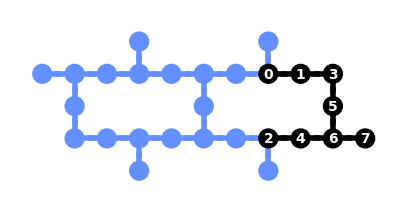

In [62]:
qiskit.visualization.plot_circuit_layout(tcirc,backend)

In [63]:
tcirc.draw()

global phase: 7π/4
                                                                           »
  ancilla_0 -> 0 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_1 -> 1 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_2 -> 2 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_3 -> 3 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_4 -> 4 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_5 -> 5 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_6 -> 6 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_7 -> 7 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_8 -> 8 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_9 -> 9 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_10 -> 10 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_11 -> 11 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_12 -> 12 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_13 -> 13 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_14 -> 14 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_15 -> 15 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_16 -> 16 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_17 -> 17 ──────────────────────────────────────────────────────────»
                 ┌─────────┐┌────┐┌─────────┐                              »
       q_0 -> 18 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─────────────────■────────────»
                 ├─────────┤├────┤├─────────┤                 │            »
       q_2 -> 19 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─────────────────┼────────────»
                 └─────────┘└────┘└─────────┘                 │            »
ancilla_18 -> 20 ─────────────────────────────────────────────┼────────────»
                 ┌─────────┐┌────┐┌─────────┐     ┌───┐     ┌─┴─┐          »
       q_1 -> 21 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■──┤ X ├──■──┤ X ├──────────»
                 └─────────┘└────┘└─────────┘  │  └─┬─┘  │  └───┘          »
       q_4 -> 22 ──────────────────────────────┼────┼────┼────■────────────»
                                             ┌─┴─┐  │  ┌─┴─┐  │       ┌───┐»
       q_3 -> 23 ────────────────────────────┤ X ├──■──┤ X ├──┼────■──┤ X ├»
                                             └───┘┌───┐└───┘  │  ┌─┴─┐└─┬─┘»
       q_5 -> 24 ──────────────────────────────■──┤ X ├──■────┼──┤ X ├──■──»
                 ┌─────────┐┌────┐┌─────────┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└───┘     »
       q_6 -> 25 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ X ├──■─